## Лабораторная работа № 5
## Бабичева Анна М8О-404Б-17
## Вариант № 2

Импортирую необходимые библиотеки, включая собственную matrix.

In [1]:
import numpy as np
import pandas as pd
import math
import pylab
import matplotlib.pyplot as plt
import random
import matrix

from numpy import arange
from numpy import meshgrid
from matplotlib import mlab
from sys import stdin
from copy import deepcopy

### Используя явную и неявную конечно-разностные схемы, а также схему Кранка-Николсона, решить начально-краевую задачу для дифференциального уравнения параболического типа. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x, t)$. Исследовать зависимость погрешности от сеточных параметров $\tau, h$.

Начально-краевая задача:

$$\frac{\partial u}{\partial t} = a\frac{\partial^2 u}{\partial x^2}, a > 0$$

$$u(0, t) = 0$$

$$u(1, t) = 1$$

$$u(x, 0) = x + sin(\pi x)$$

Данная задача является первой начально-краевой задачей для уравнения теплопроводности.

Аналитическое решение:

$$U(x,t) = x + e^{-\pi^2at}sin(\pi x)$$

Задам параметр a:

In [2]:
a = 1

Для удобства пропишу некоторые вспомогательные функции:

In [3]:
def exp_(x):
    return math.exp(x)

def sin_(x):
    return math.sin(x)

def cos_(x):
    return math.cos(x)

pi = math.pi

In [4]:
def U(x, t):
    return x + exp_(- pi ** 2 * a * t) * sin_(pi * x)

Конечно-разностные аппроксимации будут иметь вид:

$\frac{\partial u}{\partial t}\bigg|_i^k = \frac{u_i^{k+1} - u_i^k}{\tau} + O(\tau)$

где $k = 0, 1, 2, ..., K; \tau = \frac{T}{K}$

$\frac{\partial^2 u}{\partial x^2}\bigg|_i^k = \frac{u_{i+1}^k -2u_i^k + u_{i-1}^k}{h^2} + O(h^2)$

где $i = 0, 1, 2, ..., N; h = \frac{l}{N}$

Начальные и краевые условия примут вид:

$u_0^k = 0$

$u_1^k = 1$

$u_i^0 = x_i + sin(\pi x_i)$

In [5]:
def u0k(t, k):
    return 0

def uNk(t, k):
    return 1

def ui0(x, i):
    return x[i] + sin_(pi * x[i])

## Явная схема

После подстановки полученных аппроксимаций в исходное уравнение получим:

$\frac{u_i^{k+1} - u_i^k}{\tau} = a\frac{u_{i+1}^k -2u_i^k + u_{i-1}^k}{h^2} + O(\tau + h^2)$

Неизвестной сеточной функцией в такой схеме является $u_i^{k+1}$, которую можно явно выразить через остальные:

$$u_i^{k+1} = \sigma u_{i+1}^k + (1 - 2\sigma)u_i^k + \sigma u_{i-1}^k$$

$$\sigma = \frac{a^2\tau}{h^2} \leq \frac{1}{2}$$

In [22]:
def explicit(T, N, K, l=1, u0k=u0k, uNk=uNk, ui0=ui0):
    
    tau = T / K
    h = l / N
    sigma = a * tau / h ** 2
    
    if (sigma > 0.5):
        raise Exception("Измените параметры сетки!")

    x = [i * h for i in range(N + 1)]
    t = [k * tau for k in range(K + 1)]
    u = []
    u.append([ui0(x, i) for i in range(len(x))])
    
    for k in range(K + 1):
        row = [0] * len(x)
        u.append(row)        
        #for i in range(1, len(x) - 1): 
        for i in range(N - 1, 0, -1):
            u[k + 1][i] = sigma * u[k][i + 1] + (1 - 2 * sigma) * u[k][i] + sigma * u[k][i - 1]
        u[k][0] = u0k(t, k)
        u[k][N] = uNk(t, k)
    
    return x, t, u

Функции для отрисовки слоев:

In [7]:
def calc_Us(x, t, k, u, dx, l):
    xarr = np.arange(0, l + dx, dx)
    Ulist = [U(x_, t[k]) for x_ in xarr]
    ulist = u[k]
    return xarr, ulist, Ulist

def draw_level(xarr, ulist, Ulist, axes, m, n):
    axes[m, n].plot(xarr, Ulist)
    axes[m, n].scatter(x, ulist)
    axes[m, n].grid()

def draw_levels(x, t, u, dt = 4, dx=0.1, l=1):

    fig, axes = plt.subplots(2, 2)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    k = 1
    for i in range(2):
        for j in range(2):
            xarr, ulist, Ulist = calc_Us(x, t, k * dt, u, dx, l) 
            draw_level(xarr, ulist, Ulist, axes, i, j)
            k += 1    

### Слои

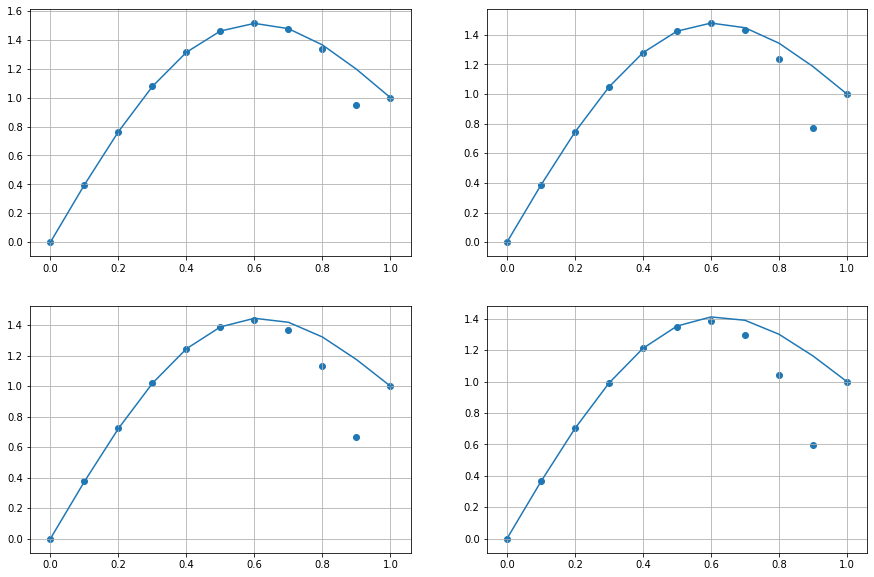

In [23]:
x, t, u = explicit(3, 10, 3000)
draw_levels(x, t, u)

Функции отрисовки графика ошибок:

In [9]:
def calc_vars_t(x, t, u):
    epss = []
    for i, t_ in enumerate(t):
        s = 0
        for j, x_ in enumerate(x):
            s += (U(x_, t_) - u[i][j]) ** 2
        epss.append(s ** 0.5)
    return epss

def calc_vars_x(x, t, u):
    epss = []
    for i, x_ in enumerate(x):
        s = 0
        for j, t_ in enumerate(t):
            s += (U(x_, t_) - u[j][i]) ** 2
        epss.append(s ** 0.5)
    return epss

def draw_variance(x, t, u):
    plt.figure(figsize=(10,7))
    plt.plot(t, calc_vars_t(x, t, u))
    plt.plot(x, calc_vars_x(x, t, u))
    plt.legend(["Ошибка по t", "Ошибка по x"])
    plt.grid()
    plt.show()

### График ошибки в зависимости от t

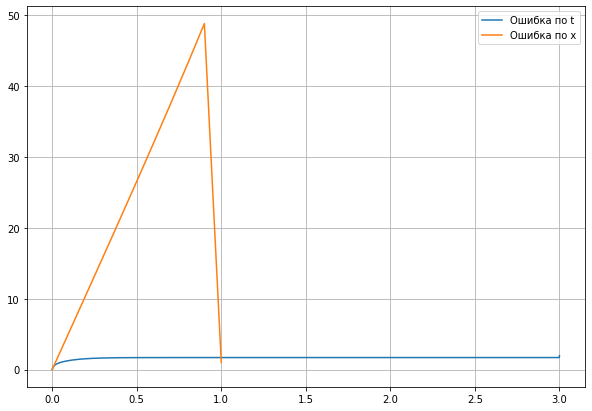

In [10]:
draw_variance(x, t, u)

In [11]:
print(u[1][9])
print(U(x[9], t[1]))

1.2059921207292055
1.2059821200271854


Данная схема условно устойчива и накладывает ограничения на параметры сетки.

## Неявная схема

При неявной схеме рассматриваются конечные разности на верхнем слое сетки. Получаем схему:

$\frac{u_i^{k+1} - u_i^k}{\tau} = a\frac{u_{i+1}^{k+1} -2u_i^{k+1} + u_{i-1}^{k+1}}{h^2} + O(\tau + h^2)$

$u_0^{k+1} = 0$

$u_1^{k+1} = 0$

$u_i^0 = x_i + sin(\pi x_i)$

Сеточную функцию на верхнем слое можно получить из решения СЛАУ методом прогонки:
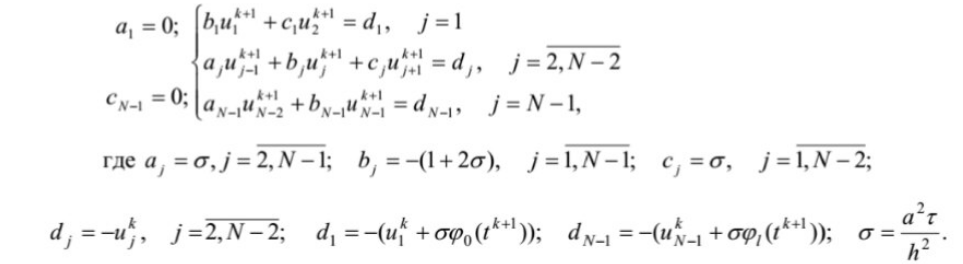

In [12]:
def implicit(T, N, K, l=1, u0k=u0k, uNk=uNk, ui0=ui0):
    
    tau = T / K
    h = l / N
    sigma = a * tau / h ** 2

    x = [i * h for i in range(N + 1)]
    t = [k * tau for k in range(K + 1)]
    u = []
    u.append([ui0(x, i) for i in range(N + 1)])
    
    for k in range(K + 1):
        A = []
        b = []
        
        for i in range(1, N):
            rows = []
            
            if i == 1:
                b.append(- (u[k][1] + sigma * u0k(t, k + 1)))
                rows = [- (1 + 2 * sigma) if (p == 1) else 0 for p in range(1, N)]
                rows[1] = sigma
                A.append(rows)
                continue
            elif i == N - 1:
                b.append(- (u[k][N - 1] + sigma * uNk(t, k + 1)))
                rows = [- (1 + 2 * sigma) if (p == N - 1) else 0 for p in range(1, N)]
                rows[N - 3] = sigma
                A.append(rows)
                continue
            else:
                b.append(- u[k][i])               
            
            for j in range(1, N):
                if (j == i - 1) | (j == i + 1):
                    rows.append(sigma)
                elif j == i:
                    rows.append(- (1 + 2 * sigma))
                else:
                    rows.append(0)   
                    
            A.append(rows)
        
        u.append([u0k(t, k + 1)] + matrix.Progonka(matrix.Matrix(A), b) + [uNk(t, k + 1)])
    
    return x, t, u

### Слои

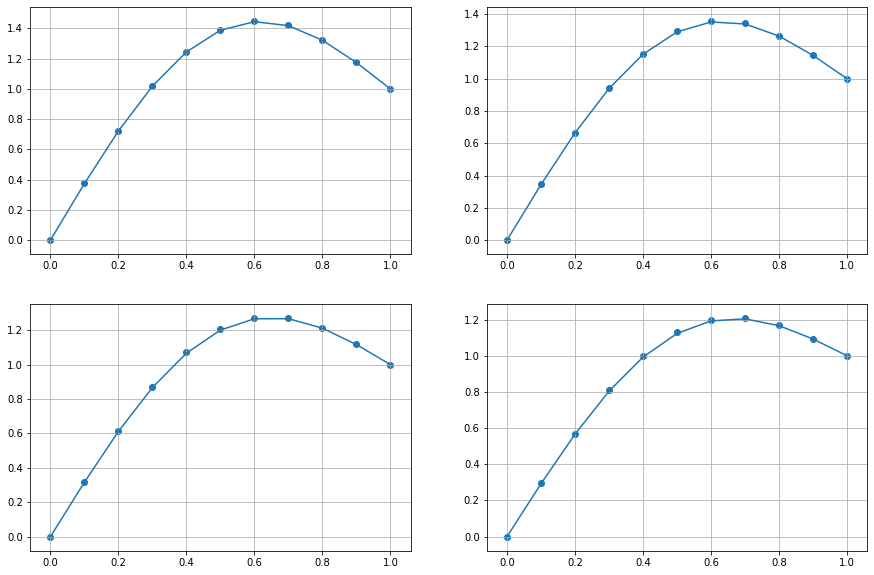

In [13]:
x, t, u = implicit(3, 10, 1000)
draw_levels(x, t, u)

### Зависимость ошибки от t

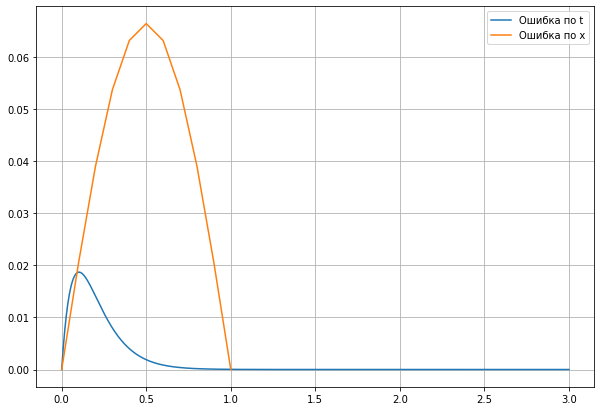

In [14]:
draw_variance(x, t, u)

In [15]:
print(u[1][9])
print(U(x[9], t[1]))

1.20020125717181
1.200001495654664


Данная схема абсолютно устойчива.

## Схема Кранка-Николсона

$\frac{u_i^{k+1} - u_i^k}{\tau} = \theta a\frac{u_{i+1}^{k+1} -2u_i^{k+1} + u_{i-1}^{k+1}}{h^2} + (1 - \theta) a\frac{u_{i+1}^{k} -2u_i^{k} + u_{i-1}^{k}}{h^2}$

При схеме Кранка-Николсона ($\theta = \frac{1}{2}$) имеем порядок порядок аппроксимации $O(\tau^2 + h^2)$.

Неявно-явная схема абсолютно устойчива при $\frac{1}{2} <= \theta <= 1$ и условно устойчива с условием $\sigma <= \frac{1}{2}$ иначе. 

In [16]:
def ex_im_plicit(T, N, K, O=0.5, l=1, u0k=u0k, uNk=uNk, ui0=ui0):
    if (O > 1) | (O < 0):
        raise Exception("Тетта между 0 и 1!")
    
    if O == 0:
        x, t, u = explicit(T, N, K, l, u0k, uNk, ui0)
    elif O == 1:
        x, t, u = implicit(T, N, K, l, u0k, uNk, ui0)
    else:
        x, t, ex_u = explicit(T, N, K, l, u0k, uNk, ui0)
        im_u = implicit(T, N, K, l, u0k, uNk, ui0)[2]
        u = np.zeros((len(t), len(x)))
        
        for i in range(u.shape[0]):
            for j in range(u.shape[1]):
                u[i][j] = O * im_u[i][j] + (1 - O) * ex_u[i][j]
    
    return x, t, u

### Слои

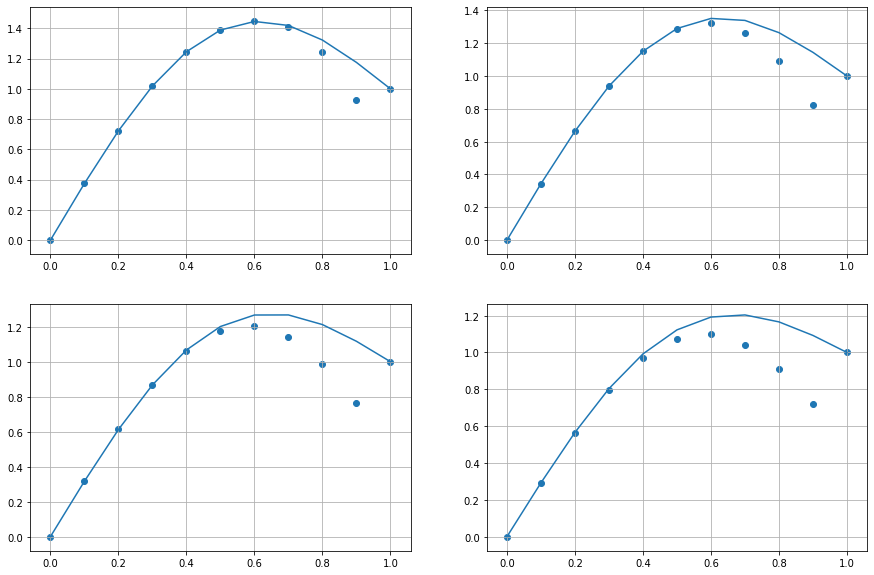

In [17]:
x, t, u = ex_im_plicit(3, 10, 1000)
draw_levels(x, t, u)

### График ошибок от t

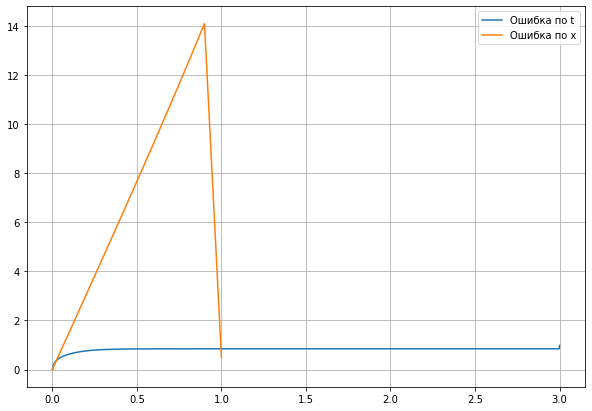

In [18]:
draw_variance(x, t, u)

In [19]:
print(u[1][9])
print(U(x[9], t[1]))

1.2000718153047654
1.200001495654664
